<a href="https://colab.research.google.com/github/DenisPotekhin2002/Generative-Models-2025/blob/main/Assignment%203/3_tricks_metrics_prev_HW_colab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 3

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

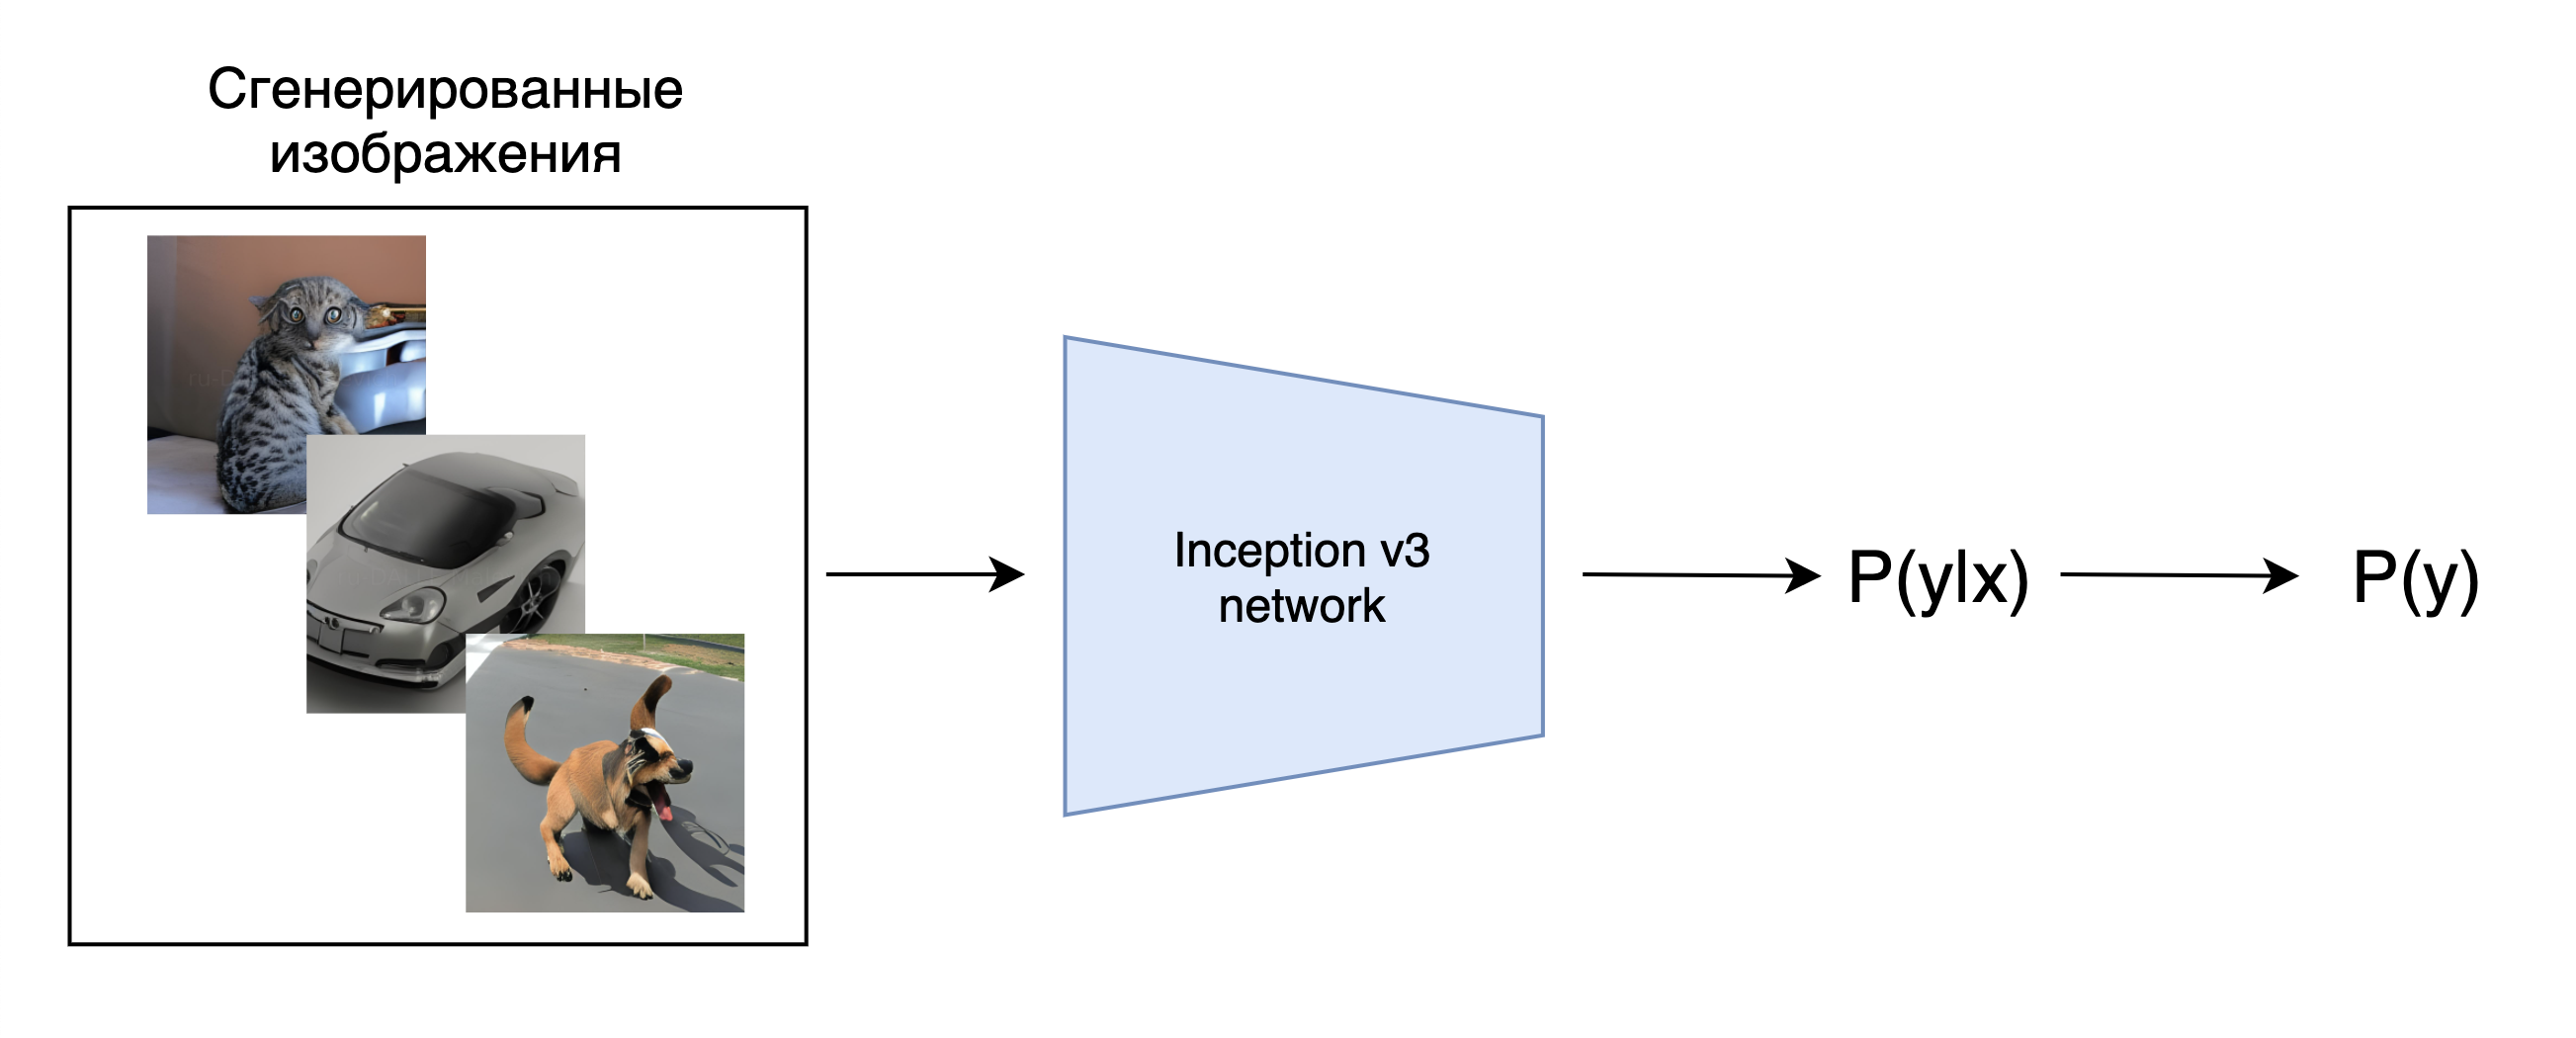

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

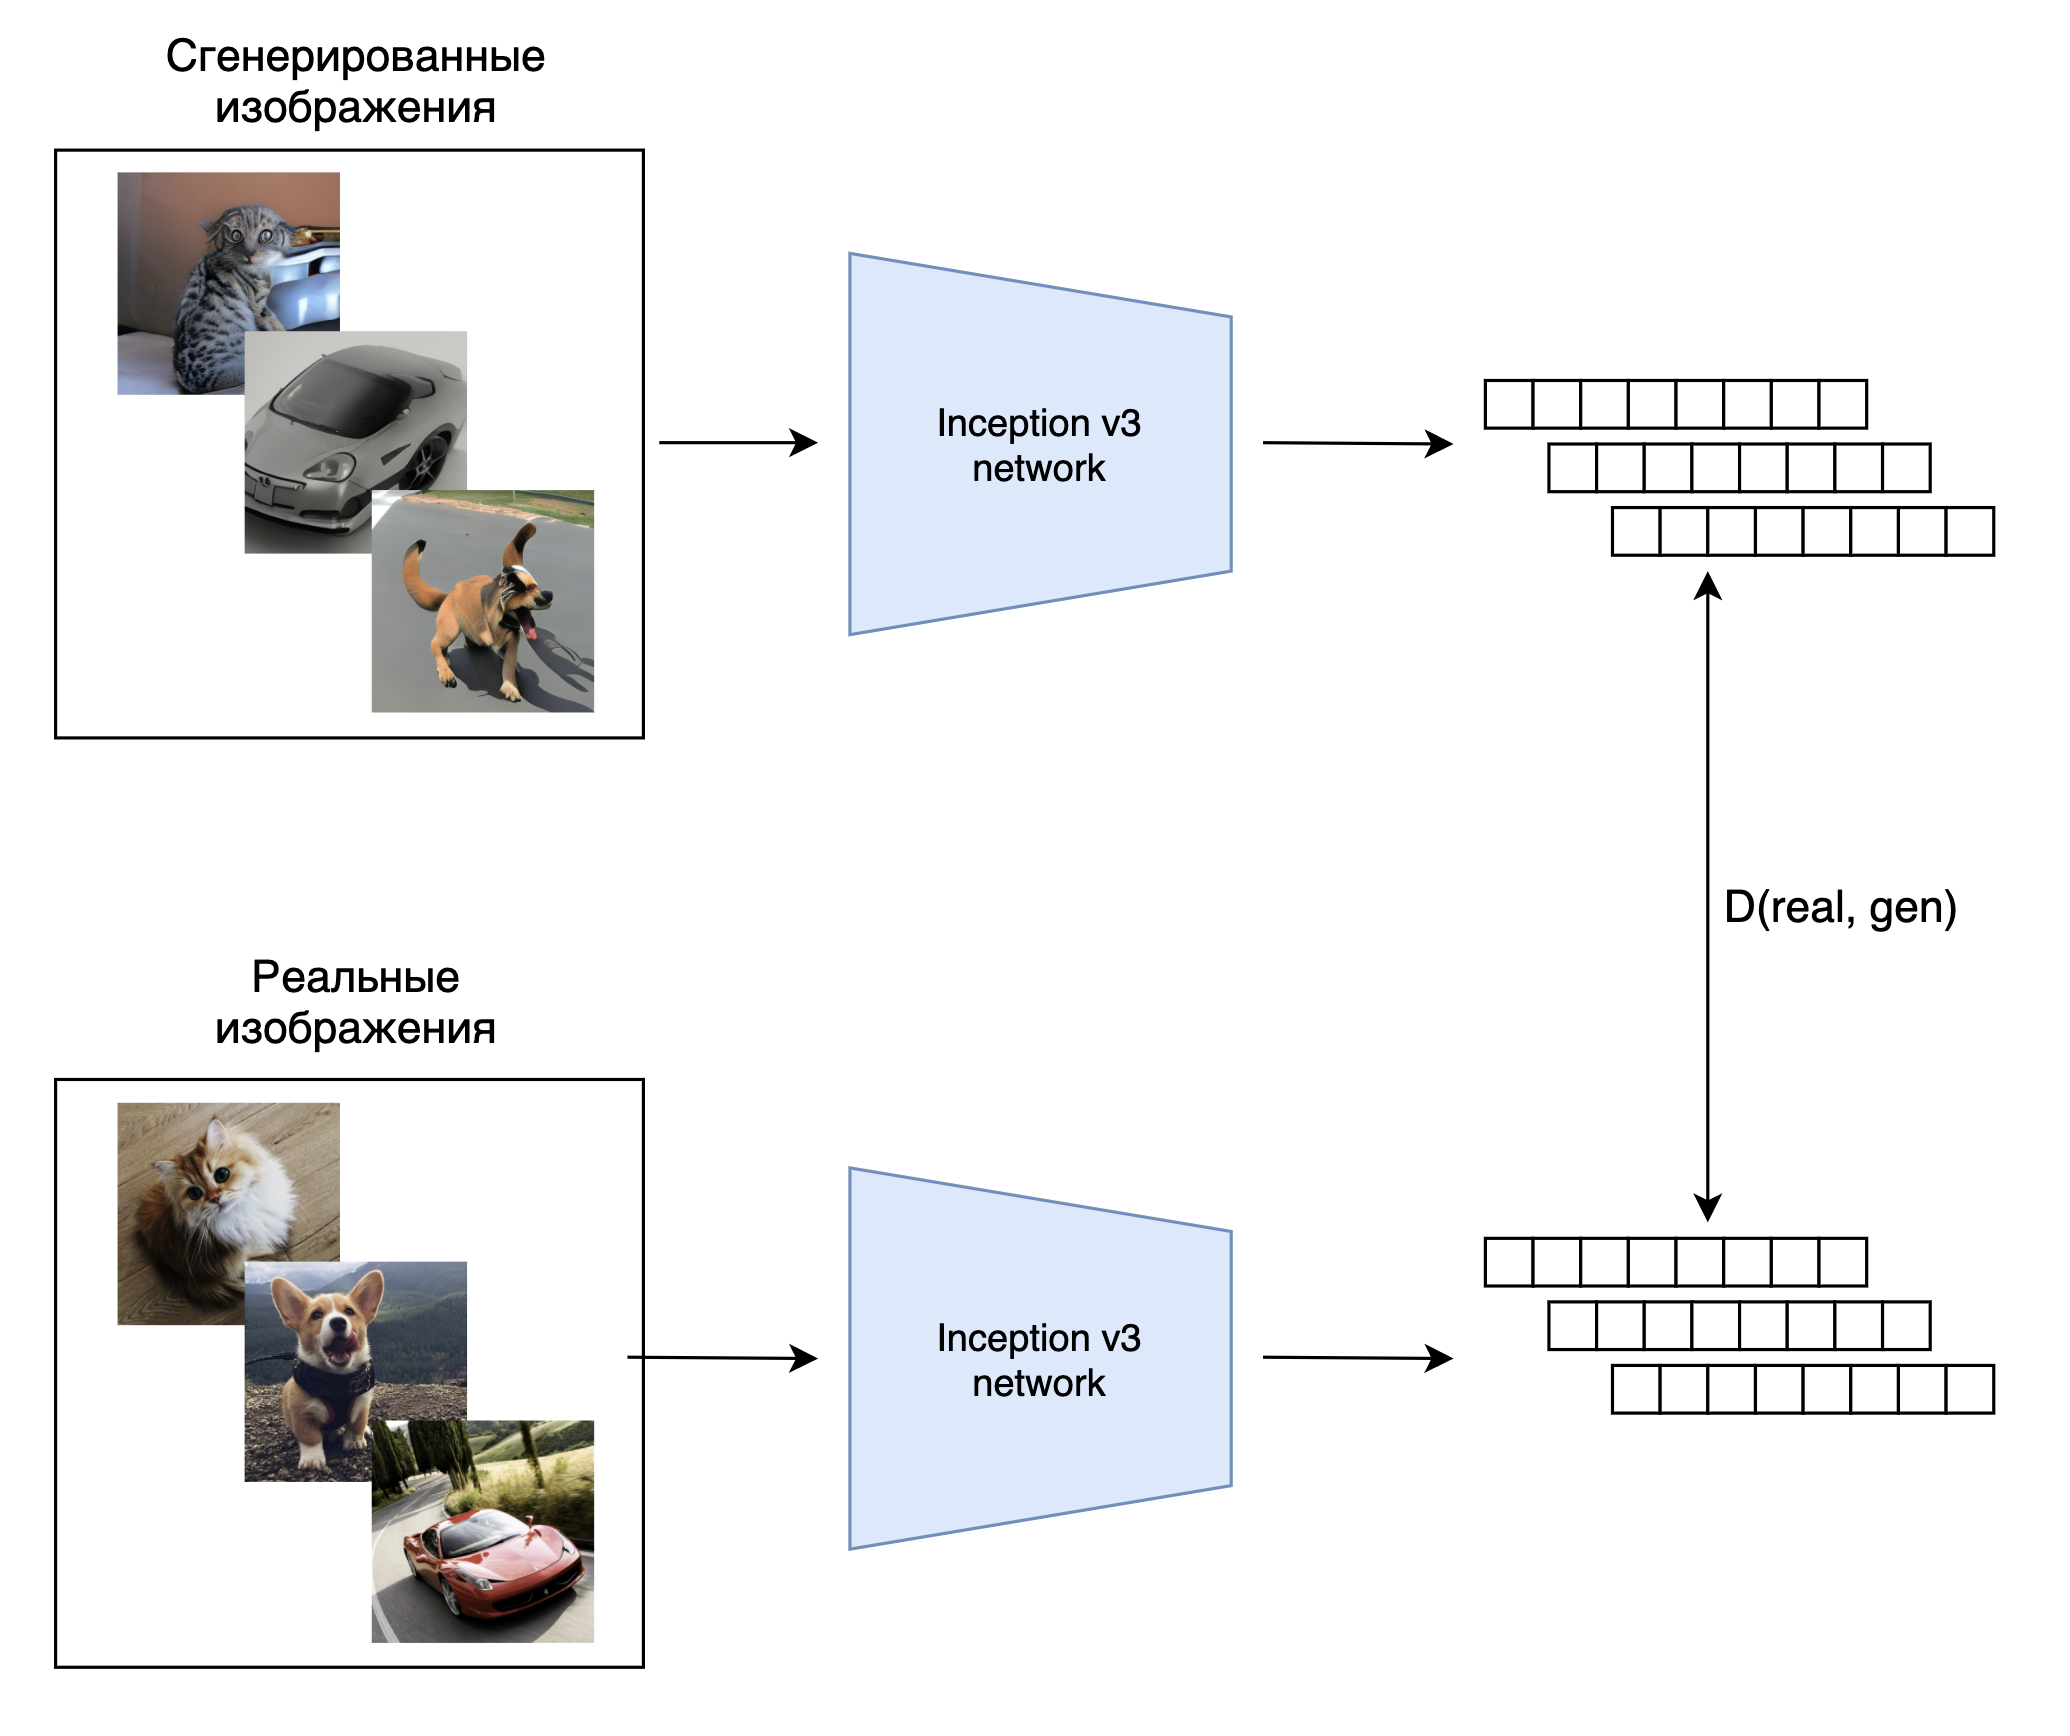

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN и диффузию (DDPM) на датасете CIFAR10. Для GAN вы можете использовать методы регуляризации, чтобы улучшить его качество, например label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных (вспомогательный код для трюков в ганах приведен в ноутбуке). Переиспользуйте код из 1 и 2 домашней работы.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей. Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
GAN | |
Diffusion | |
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 50
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.00005
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

100%|██████████| 170M/170M [00:03<00:00, 47.1MB/s]


Label:  6


(array([ 140.,  578., 1378., 1406., 1163., 1691., 1246., 1402., 1351.,
         602.,  440.,  344.,  279.,  185.,   83.]),
 array([-0.99215686, -0.86091506, -0.72967321, -0.59843135, -0.46718955,
        -0.33594775, -0.20470589, -0.07346404,  0.05777776,  0.18901956,
         0.32026136,  0.45150328,  0.58274508,  0.71398687,  0.84522879,
         0.97647059]),
 <BarContainer object of 15 artists>)

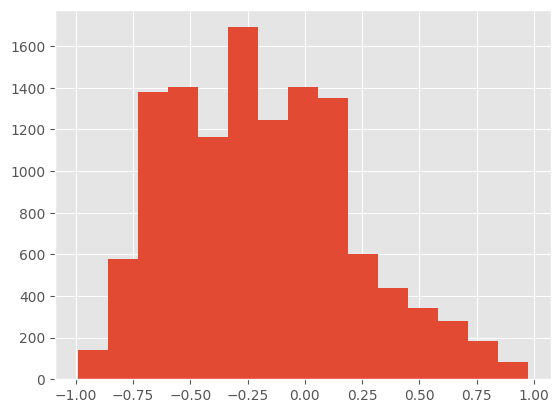

In [2]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

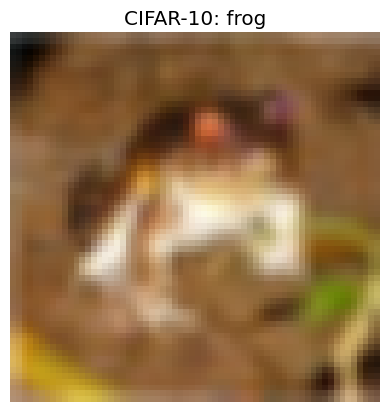

In [3]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    # write your code
    out = (img + 1) / 2
    return out.clamp(0, 1)

# show image sample with matplotlib
def show_image(img_tensor, denormalize=True, title=None):
    if denormalize:
        img_tensor = denorm(img_tensor)

    img_np = img_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img_np)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

show_image(img, title=f"CIFAR-10: {cifar_dataset.classes[label]}")

In [4]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(
    cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers,
    pin_memory=True if CFG.device == "cuda" else False
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Спектральная нормализация

In [5]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [6]:
import torch.nn as nn
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator with dropout
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),  # Add dropout

            SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),  # Add dropout

            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),  # Add dropout

            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),  # Add dropout

            SpectralNorm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [7]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)

# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ndf).to(CFG.device)

In [8]:
# show the output of model
y = G(torch.randn(2, CFG.nz, 1, 1).to(CFG.device))

In [9]:
# feel free to reuse your training functions
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
CFG.beta1 = 0.5
optimizerG = torch.optim.Adam(G.parameters(), lr=CFG.lr, betas=(CFG.beta1, 0.999))
optimizerD = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(CFG.beta1, 0.999))

Discriminator Training

In [10]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator
def add_noise_to_labels(labels, noise_level=0.1):
    noise = torch.randn_like(labels) * noise_level
    return torch.clamp(labels + noise, 0, 1)

In [11]:
def reset_grad():
    optimizerD.zero_grad()
    optimizerG.zero_grad()

# Define a variable for label smoothing
LABEL_SMOOTH = 0.8  # Reduced from 0.9 to make labels less extreme

def add_noise_to_labels(labels, noise_level=0.2):  # Increased noise level
    """Add noise to labels for label smoothing"""
    noise = torch.randn_like(labels) * noise_level
    return torch.clamp(labels + noise, 0.1, 0.9)  # Keep within reasonable bounds

def train_discriminator(images):
    batch_size = images.size(0)

    # Create the labels which are later used as input for the BCE loss
    # Use more aggressive label smoothing
    real_labels = torch.ones(batch_size, device=CFG.device) * LABEL_SMOOTH
    fake_labels = torch.zeros(batch_size, device=CFG.device) * (1 - LABEL_SMOOTH)

    # Add more noise to labels
    real_labels = add_noise_to_labels(real_labels, noise_level=0.15)
    fake_labels = add_noise_to_labels(fake_labels, noise_level=0.15)

    # Add noise to real images before feeding to discriminator
    images_noisy = images + torch.randn_like(images) * 0.05  # Add 5% noise

    outputs = D(images_noisy)
    # Loss for real images
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, CFG.nz, 1, 1, device=CFG.device)
    fake_images = G(z)

    # Add noise to fake images too
    fake_images_noisy = fake_images + torch.randn_like(fake_images) * 0.05

    outputs = D(fake_images_noisy.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Clip gradients to prevent explosion
    torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)

    # Adjust the parameters using backprop
    optimizerD.step()

    return d_loss, real_score, fake_score

Generator Training

In [12]:
#Add gauss noise
#noise = 0.005*np.random.uniform()*np.amax(sound)

In [13]:
def train_generator():
    # Generate fake images and calculate loss
    batch_size = CFG.batch_size

    # Add Gaussian noise to latent vectors with variable noise
    z = np.random.normal(0, 1, (batch_size, CFG.nz))
    noise_level = 0.01 * np.random.uniform() * np.max(np.abs(z))  # Reduced noise
    z = z.astype('float32') + noise_level * np.random.normal(size=z.shape)
    z = torch.tensor(z, dtype=torch.float32, device=CFG.device).view(batch_size, CFG.nz, 1, 1)

    fake_images = G(z)
    labels = torch.ones(batch_size, device=CFG.device) * LABEL_SMOOTH  # Use same label smoothing

    # Add noise to labels
    labels = add_noise_to_labels(labels, noise_level=0.1)

    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()

    # Clip gradients for generator too
    torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)

    optimizerG.step()

    return g_loss, fake_images

## Start the training process

In [14]:
def save_fake_images(index):
    batch_size = 100
    z = np.random.normal(0, 1, (batch_size, CFG.nz))
    noise = 0.005 * np.random.uniform() * np.max(np.abs(z))
    z = z.astype('float32') + noise * np.random.normal(size=z.shape)
    z = torch.tensor(z, dtype=torch.float32, device=CFG.device).view(batch_size, CFG.nz, 1, 1)

    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = f'fake_images_cifar_improved-{index:04d}.png'
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [15]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, _ = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/391], d_loss: 0.9533, g_loss: 1.4618, D(x): 0.79, D(G(z)): 0.11
Saving fake_images_cifar_improved-0001.png
Epoch [1/50], Step [200/391], d_loss: 0.9672, g_loss: 2.1805, D(x): 0.76, D(G(z)): 0.21
Saving fake_images_cifar_improved-0002.png
Epoch [2/50], Step [200/391], d_loss: 1.1067, g_loss: 1.2056, D(x): 0.79, D(G(z)): 0.35
Saving fake_images_cifar_improved-0003.png
Epoch [3/50], Step [200/391], d_loss: 1.0481, g_loss: 0.9583, D(x): 0.63, D(G(z)): 0.13
Saving fake_images_cifar_improved-0004.png
Epoch [4/50], Step [200/391], d_loss: 1.0759, g_loss: 1.1990, D(x): 0.64, D(G(z)): 0.25
Saving fake_images_cifar_improved-0005.png
Epoch [5/50], Step [200/391], d_loss: 1.1408, g_loss: 1.6143, D(x): 0.64, D(G(z)): 0.34
Saving fake_images_cifar_improved-0006.png
Epoch [6/50], Step [200/391], d_loss: 1.2025, g_loss: 1.0018, D(x): 0.67, D(G(z)): 0.40
Saving fake_images_cifar_improved-0007.png
Epoch [7/50], Step [200/391], d_loss: 1.2853, g_loss: 0.9070, D(x): 0.43, D(G(z)): 

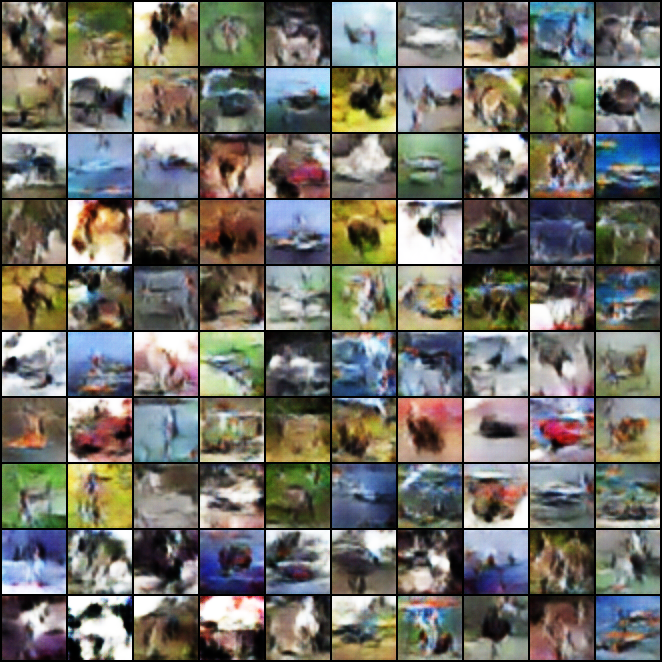

In [16]:
Image(os.path.join(CFG.sample_dir, 'fake_images_cifar_improved-0018.png'))

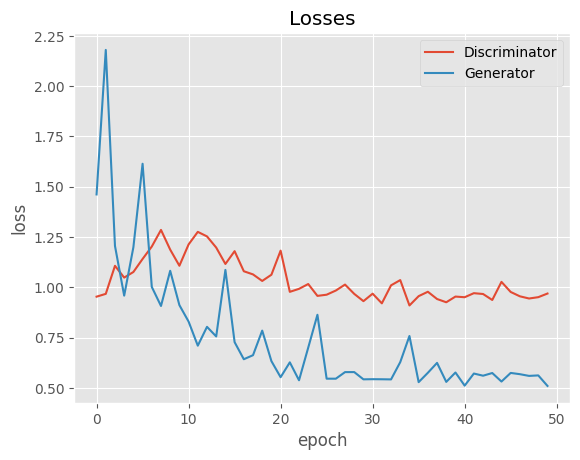

In [17]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

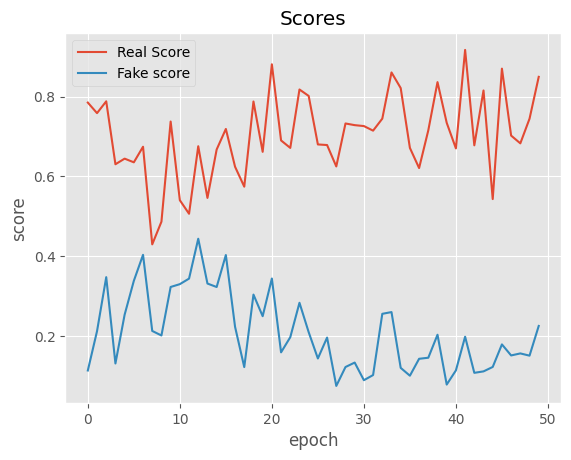

In [18]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [19]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 342 (delta 55), reused 96 (delta 46), pack-reused 230 (from 1)
Receiving objects: 100% (342/342), 93.34 KiB | 7.18 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [20]:
%cd pytorch-gan-metrics
#### Prepare Statistics for FID


/content/pytorch-gan-metrics


In [21]:
!pip install -e .

Obtaining file:///content/pytorch-gan-metrics
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pytorch_image_generation_metrics
    Found existing installation: pytorch-image-generation-metrics 0.6.1
    Uninstalling pytorch-image-generation-metrics-0.6.1:
      Successfully uninstalled pytorch-image-generation-metrics-0.6.1
  Running setup.py develop for pytorch_image_generation_metrics


In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import subprocess
from pytorch_image_generation_metrics import (get_inception_score,
                                             get_fid,
                                             get_inception_score_and_fid)

# ======================= 1. CREATE FID REFERENCE .NPZ FILE =======================
real_dir = './cifar10_real_images'
stats_path = './cifar10_fid_ref.npz'

if not os.path.exists(stats_path):
    os.makedirs(real_dir, exist_ok=True)
    for i in range(50000):
        img, _ = cifar_dataset[i]
        img = (img + 1) / 2.0  # Denormalize from [-1, 1] to [0, 1]
        save_image(img, os.path.join(real_dir, f'{i:05d}.png'))

    subprocess.run([
        'python', '-m', 'pytorch_image_generation_metrics.fid_ref',
        '--path', real_dir,
        '--output', stats_path
    ], capture_output=True)

# ======================= 2. GENERATOR DATASET & DATALOADER =======================
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim, num_samples=500):
        self.G = G
        self.z_dim = z_dim
        self.num_samples = num_samples
        self.G.eval()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        with torch.no_grad():
            z = torch.randn(1, self.z_dim, 1, 1).cuda()
            img = self.G(z)
            if isinstance(img, (tuple, list)):
                img = img[0]
            img = (img + 1) / 2.0  # Normalize to [0, 1]
            img = torch.clamp(img, 0, 1)
            return img.squeeze(0)

dataset = GeneratorDataset(G, CFG.nz, num_samples=500)
loader = DataLoader(dataset, batch_size=50, shuffle=False, num_workers=0)

# ======================= 3. CALCULATE ALL METRICS =======================
print("="*60)
print("CALCULATING GAN METRICS")
print("="*60)

# Reset DataLoader for each calculation
loader_combined = DataLoader(dataset, batch_size=50, shuffle=False, num_workers=0)
loader_is = DataLoader(dataset, batch_size=50, shuffle=False, num_workers=0)
loader_fid = DataLoader(dataset, batch_size=50, shuffle=False, num_workers=0)

# Calculate IS and FID together
print("\nCalculating IS and FID simultaneously...")
(IS_combined, IS_std_combined), FID_combined = get_inception_score_and_fid(loader_combined, stats_path, device='cuda')
print(f"   IS: {IS_combined:.4f} ± {IS_std_combined:.4f}")
print(f"   FID: {FID_combined:.4f}")

# Calculate Inception Score only
print("\nCalculating Inception Score only...")
IS_sep, IS_std_sep = get_inception_score(loader_is, device='cuda')
print(f"   IS: {IS_sep:.4f} ± {IS_std_sep:.4f}")

# Calculate FID only
print("\nCalculating FID only...")
FID_sep = get_fid(loader_fid, stats_path, device='cuda')
print(f"   FID: {FID_sep:.4f}")

# Use the combined results for the final table
IS_final, IS_std_final, FID_final = IS_combined, IS_std_combined, FID_combined

# ======================= 4. CREATE COMPARISON TABLE =======================
print("\n" + "="*60)
print("EVALUATION RESULTS COMPARISON TABLE")
print("="*60)
print(f"{'Model':<15} | {'IS':<18} | {'FID':<10}")
print("-" * 50)
print(f"{'GAN (Your Model)':<15} | {IS_final:.2f} ± {IS_std_final:.2f} | {FID_final:.4f}")
print(f"{'Diffusion':<15} | {'TBD':<18} | {'TBD':<10}")
print(f"{'CIFAR10':<15} | 10.98 ± 0.22     | 3.1508")
print("="*60)

CALCULATING GAN METRICS

[OPTION A] Calculating IS and FID simultaneously...
   IS: 3.0596 ± 0.2714
   FID: 192.3947

[OPTION B] Calculating Inception Score only...
   IS: 2.9004 ± 0.1955

[OPTION C] Calculating FID only...
   FID: 194.6711

EVALUATION RESULTS COMPARISON TABLE
Model           | IS                 | FID       
--------------------------------------------------
GAN (Your Model) | 3.06 ± 0.27 | 192.3947
Diffusion       | TBD                | TBD       
CIFAR10         | 10.98 ± 0.22     | 3.1508


In [ ]:
# ==================== DIFFUSION MODEL (DDPM) FOR CIFAR-10 ====================

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import os
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

# Import UNet from your file
from unet import UNet

# DenoiseDiffusion class (from Assignment 1, adapted for CIFAR-10)
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        c = consts.gather(-1, t)
        return c.reshape(-1, 1, 1, 1)

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor):
        mean = self.gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - self.gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps=None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        alpha_bar = self.gather(self.alpha_bar, t)
        alpha = self.gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar).sqrt()
        mean = (xt - eps_coef * eps_theta) / alpha.sqrt()
        var = self.gather(self.sigma2, t)
        eps = torch.randn_like(xt)
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise=None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
        if noise is None:
            noise = torch.randn_like(x0)
        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.eps_model(xt, t)
        return F.mse_loss(noise, eps_theta)

# CIFAR-10 Dataset for diffusion
class CIFAR10Dataset(torchvision.datasets.CIFAR10):
    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        super().__init__("./data", train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]

# Denormalize function for visualization
def denorm(tensor):
    return (tensor + 1) / 2.0

# Diffusion Model Configuration
class DiffusionConfig:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.image_channels = 3
        self.image_size = 32
        self.n_channels = 64
        self.channel_multipliers = [1, 2, 2, 4]
        self.is_attention = [False, False, False, True]
        self.n_steps = 1000
        self.batch_size = 64
        self.n_samples = 500
        self.learning_rate = 1e-4
        self.epochs = 20
        self.sample_dir = "./diffusion_samples/"
        os.makedirs(self.sample_dir, exist_ok=True)

        self.eps_model = None
        self.diffusion = None
        self.dataset = None
        self.data_loader = None
        self.optimizer = None

    def init(self):
        print("Initializing Diffusion Model (DDPM) for CIFAR-10...")
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        self.dataset = CIFAR10Dataset(self.image_size)
        self.data_loader = DataLoader(
            self.dataset, self.batch_size, shuffle=True, pin_memory=True
        )

        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)
        print(f"Model initialized on {self.device}")
        print(f"Total parameters: {sum(p.numel() for p in self.eps_model.parameters()):,}")

    def sample(self, n_samples=None, save_prefix=None):
        if n_samples is None:
            n_samples = self.n_samples

        with torch.no_grad():
            x = torch.randn(
                (n_samples, self.image_channels, self.image_size, self.image_size),
                device=self.device
            )

            # Denoising process with progress bar
            pbar = tqdm(range(self.n_steps), desc="Sampling")
            for t_ in pbar:
                t = self.n_steps - t_ - 1
                x = self.diffusion.p_sample(
                    x, x.new_full((n_samples,), t, dtype=torch.long)
                )
                pbar.set_postfix({"step": t})

            # Denormalize to [0, 1] and clamp
            samples = denorm(x)
            samples = torch.clamp(samples, 0, 1)

            # Save samples if requested
            if save_prefix:
                # Save grid of 64 images
                grid = make_grid(samples[:64], nrow=8, padding=2)
                save_image(grid, os.path.join(self.sample_dir, f"{save_prefix}.png"))
                print(f"✓ Saved samples to {os.path.join(self.sample_dir, f'{save_prefix}.png')}")

            return samples.detach().cpu()

    def train_epoch(self, epoch):
        self.eps_model.train()
        total_loss = 0
        batch_count = 0

        pbar = tqdm(self.data_loader, desc=f"Epoch {epoch + 1}/{self.epochs}")
        for batch_idx, data in enumerate(pbar):
            data = data.to(self.device)
            self.optimizer.zero_grad()

            loss = self.diffusion.loss(data)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            batch_count += 1

            # Update progress bar
            avg_loss = total_loss / batch_count
            pbar.set_postfix({
                "loss": f"{loss.item():.6f}",
                "avg_loss": f"{avg_loss:.6f}"
            })

        return total_loss / batch_count

    def run(self):
        print(f"\nStarting training for {self.epochs} epochs...")
        for epoch in range(self.epochs):
            # Train one epoch
            avg_loss = self.train_epoch(epoch)

            # Generate and save samples every epoch
            print(f"Epoch {epoch + 1}/{self.epochs} completed. Loss: {avg_loss:.6f}")
            print("Generating samples...")

            samples = self.sample(n_samples=16, save_prefix=f"epoch_{epoch+1}")

            # Visualize samples
            if epoch % 2 == 0 or epoch == self.epochs - 1:
                fig, axes = plt.subplots(2, 8, figsize=(16, 4))
                axes = axes.flatten()

                for i in range(min(16, len(samples))):
                    img = samples[i].permute(1, 2, 0).numpy()
                    axes[i].imshow(img)
                    axes[i].axis('off')

                plt.suptitle(f'Diffusion Samples - Epoch {epoch + 1}')
                plt.tight_layout()
                plt.savefig(os.path.join(self.sample_dir, f"epoch_{epoch+1}_viz.png"), dpi=150)
                plt.close()

                print(f"✓ Saved visualization to {os.path.join(self.sample_dir, f'epoch_{epoch+1}_viz.png')}")

# ==================== TRAIN DIFFUSION MODEL ====================
print("="*70)
print("TRAINING DIFFUSION MODEL (DDPM) ON CIFAR-10")
print("="*70)

diffusion_cfg = DiffusionConfig()
diffusion_cfg.init()
diffusion_cfg.run()

# ==================== CALCULATE METRICS FOR DIFFUSION ====================
print("\n" + "="*70)
print("CALCULATING METRICS FOR DIFFUSION MODEL")
print("="*70)

# Create Diffusion Dataset for evaluation
class DiffusionDataset(Dataset):
    def __init__(self, diffusion_cfg, num_samples=500):
        self.diffusion_cfg = diffusion_cfg
        self.num_samples = num_samples
        print(f"Generating {num_samples} evaluation samples from diffusion model...")
        self.samples = diffusion_cfg.sample(num_samples)
        self.samples = torch.clamp(self.samples, 0, 1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.samples[index]

# Generate evaluation samples
diffusion_dataset = DiffusionDataset(diffusion_cfg, num_samples=500)
diffusion_loader = DataLoader(diffusion_dataset, batch_size=50, shuffle=False, num_workers=0)

# Calculate metrics
from pytorch_image_generation_metrics import get_inception_score_and_fid, get_inception_score, get_fid

stats_path = './cifar10_fid_ref.npz'

# Calculate combined IS and FID
(IS_diff, IS_std_diff), FID_diff = get_inception_score_and_fid(
    diffusion_loader, stats_path, device='cuda'
)

print(f" Diffusion Inception Score: {IS_diff:.4f} ± {IS_std_diff:.4f}")
print(f" Diffusion FID: {FID_diff:.4f}")

# ==================== FINAL COMPARISON TABLE ====================
print("\n" + "="*70)
print("FINAL COMPARISON TABLE")
print("="*70)

IS_gan, IS_std_gan, FID_gan = IS_final, IS_std_final, FID_final

print(f"{'Model':<12} | {'Inception Score':<20} | {'FID':<12}")
print("-" * 50)
print(f"{'GAN':<12} | {IS_gan:.2f} ± {IS_std_gan:.2f} | {FID_gan:.4f}")
print(f"{'Diffusion':<12} | {IS_diff:.2f} ± {IS_std_diff:.2f} | {FID_diff:.4f}")
print(f"{'CIFAR-10':<12} | 10.98 ± 0.22       | 3.1508")
print("="*70)

# ==================== INDIVIDUAL METRICS CALCULATION ====================
print("\n" + "="*70)
print("INDIVIDUAL METRICS CALCULATION")
print("="*70)

# Reset loaders for individual calculations
diffusion_loader_is = DataLoader(diffusion_dataset, batch_size=50, shuffle=False, num_workers=0)
diffusion_loader_fid = DataLoader(diffusion_dataset, batch_size=50, shuffle=False, num_workers=0)

# Individual calculations
IS_diff_only, IS_std_diff_only = get_inception_score(diffusion_loader_is, device='cuda')
FID_diff_only = get_fid(diffusion_loader_fid, stats_path, device='cuda')

print(f"Diffusion - IS only: {IS_diff_only:.4f} ± {IS_std_diff_only:.4f}")
print(f"Diffusion - FID only: {FID_diff_only:.4f}")
print(f"Diffusion - IS+FID: {IS_diff:.4f} ± {IS_std_diff:.4f} / {FID_diff:.4f}")

# Summary
print("\n" + "="*70)
print("EVALUATION COMPLETE")
print("="*70)
print(f"Diffusion model trained for {diffusion_cfg.epochs} epochs")
print(f"Samples saved to: {diffusion_cfg.sample_dir}")
print(f"Metrics calculated on {len(diffusion_dataset)} generated images")
print("="*70)

/content/unet.py:12: SyntaxWarning: invalid escape sequence '\c'
  $$x \cdot \sigma(x)$$


TRAINING DIFFUSION MODEL (DDPM) ON CIFAR-10
Initializing Diffusion Model (DDPM) for CIFAR-10...


100%|██████████| 170M/170M [00:06<00:00, 26.8MB/s]


Model initialized on cuda
Total parameters: 167,777,987

Starting training for 20 epochs...


Epoch 1/20: 100%|██████████| 782/782 [05:12<00:00,  2.50it/s, loss=0.049992, avg_loss=0.090758]


Epoch 1/20 completed. Loss: 0.090758
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_1.png
✓ Saved visualization to ./diffusion_samples/epoch_1_viz.png


Epoch 2/20: 100%|██████████| 782/782 [05:12<00:00,  2.51it/s, loss=0.024192, avg_loss=0.047908]


Epoch 2/20 completed. Loss: 0.047908
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_2.png


Epoch 3/20: 100%|██████████| 782/782 [05:12<00:00,  2.50it/s, loss=0.101008, avg_loss=0.042211]


Epoch 3/20 completed. Loss: 0.042211
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.23it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_3.png
✓ Saved visualization to ./diffusion_samples/epoch_3_viz.png


Epoch 4/20: 100%|██████████| 782/782 [05:12<00:00,  2.50it/s, loss=0.026263, avg_loss=0.039934]


Epoch 4/20 completed. Loss: 0.039934
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.23it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_4.png


Epoch 5/20: 100%|██████████| 782/782 [05:12<00:00,  2.50it/s, loss=0.058173, avg_loss=0.037948]


Epoch 5/20 completed. Loss: 0.037948
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_5.png
✓ Saved visualization to ./diffusion_samples/epoch_5_viz.png


Epoch 6/20: 100%|██████████| 782/782 [05:12<00:00,  2.50it/s, loss=0.038018, avg_loss=0.037154]


Epoch 6/20 completed. Loss: 0.037154
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_6.png


Epoch 7/20: 100%|██████████| 782/782 [05:12<00:00,  2.50it/s, loss=0.056118, avg_loss=0.036478]


Epoch 7/20 completed. Loss: 0.036478
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_7.png
✓ Saved visualization to ./diffusion_samples/epoch_7_viz.png


Epoch 8/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.036466, avg_loss=0.040464]


Epoch 8/20 completed. Loss: 0.040464
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.27it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_8.png


Epoch 9/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.034629, avg_loss=0.038246]


Epoch 9/20 completed. Loss: 0.038246
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_9.png
✓ Saved visualization to ./diffusion_samples/epoch_9_viz.png


Epoch 10/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.033610, avg_loss=0.036673]


Epoch 10/20 completed. Loss: 0.036673
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.26it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_10.png


Epoch 11/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.057164, avg_loss=0.036323]


Epoch 11/20 completed. Loss: 0.036323
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.22it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_11.png
✓ Saved visualization to ./diffusion_samples/epoch_11_viz.png


Epoch 12/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.044370, avg_loss=0.038604]


Epoch 12/20 completed. Loss: 0.038604
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.27it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_12.png


Epoch 13/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.021338, avg_loss=0.036662]


Epoch 13/20 completed. Loss: 0.036662
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_13.png
✓ Saved visualization to ./diffusion_samples/epoch_13_viz.png


Epoch 14/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.012696, avg_loss=0.036509]


Epoch 14/20 completed. Loss: 0.036509
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_14.png


Epoch 15/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.018304, avg_loss=0.035770]


Epoch 15/20 completed. Loss: 0.035770
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.26it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_15.png
✓ Saved visualization to ./diffusion_samples/epoch_15_viz.png


Epoch 16/20: 100%|██████████| 782/782 [05:11<00:00,  2.51it/s, loss=0.027132, avg_loss=0.035414]


Epoch 16/20 completed. Loss: 0.035414
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.22it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_16.png


Epoch 17/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.023236, avg_loss=0.034953]


Epoch 17/20 completed. Loss: 0.034953
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_17.png
✓ Saved visualization to ./diffusion_samples/epoch_17_viz.png


Epoch 18/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.060220, avg_loss=0.037252]


Epoch 18/20 completed. Loss: 0.037252
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_18.png


Epoch 19/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.025628, avg_loss=0.070337]


Epoch 19/20 completed. Loss: 0.070337
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.26it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_19.png
✓ Saved visualization to ./diffusion_samples/epoch_19_viz.png


Epoch 20/20: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s, loss=0.024744, avg_loss=0.038993]


Epoch 20/20 completed. Loss: 0.038993
Generating samples...


Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.26it/s, step=0]


✓ Saved samples to ./diffusion_samples/epoch_20.png
✓ Saved visualization to ./diffusion_samples/epoch_20_viz.png

CALCULATING METRICS FOR DIFFUSION MODEL
Generating 500 evaluation samples from diffusion model...


Sampling: 100%|██████████| 1000/1000 [12:53<00:00,  1.29it/s, step=0]


✅ Diffusion Inception Score: 2.9282 ± 0.1498
✅ Diffusion FID: 175.1744

FINAL COMPARISON TABLE
Model        | Inception Score      | FID         
--------------------------------------------------
GAN          | 3.06 ± 0.27 | 192.3947
Diffusion    | 2.93 ± 0.15 | 175.1744
CIFAR-10     | 10.98 ± 0.22       | 3.1508

INDIVIDUAL METRICS CALCULATION
Diffusion - IS only: 2.9282 ± 0.1498
Diffusion - FID only: 175.1744
Diffusion - IS+FID: 2.9282 ± 0.1498 / 175.1744

EVALUATION COMPLETE
Diffusion model trained for 20 epochs
Samples saved to: ./diffusion_samples/
Metrics calculated on 500 generated images


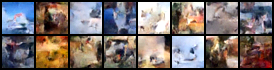

In [29]:
Image(os.path.join('./diffusion_samples', 'epoch_18.png'))

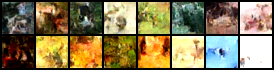

In [30]:
Image(os.path.join('./diffusion_samples', 'epoch_20.png'))